# A first finite DMRG Example

Like `examples/d_dmrg.py`, this notebook shows the basic interface for DMRG.
It initalized the transverse field Ising model $H = J XX + g Z$ at the critical point $J=g=1$,
and a finite MPS in the all-up state $|\uparrow\cdots \uparrow\rangle$.
It then runs DMRG to find the ground state.
Finally, we look at the profile of the entanglement-cuts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

tenpy.tools.misc.setup_logging(to_stdout="INFO")

In [3]:
L = 100

In [4]:
model_params = {
    'J': 1. , 'g': 1.,  # critical
    'L': L,
    'bc_MPS': 'finite',    
}

M = TFIChain(model_params)

INFO    : TFIChain: reading 'bc_MPS'='finite'
INFO    : TFIChain: reading 'L'=100
INFO    : TFIChain: reading 'J'=1.0
INFO    : TFIChain: reading 'g'=1.0


In [5]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

In [6]:
dmrg_params = {
    'mixer': None,  # setting this to True helps to escape local minima
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'verbose': True,
    'combine': True
}
eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params) 
E, psi = eng.run() # the main work; modifies psi in place

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'combine'=True
INFO    : TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=-126.9290280127259649, max S=0.3829294433343728, age=100, norm_err=1.2e-01
Current memory usage 118.7MB, wall time: 3.0s
Delta E = nan, Delta S = 3.7668e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.4211e-13
chi: 4
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-126.9618018027223059, max S=0.5530509009591875, age=100, norm_err=7.0e-03
Current memory usage 122.5MB, wall time: 5.3s
Delta E = -3.2774e-02, Delta S = 1.3418e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 1.8474e-13
chi: 16
INFO    : Running sweep 

## Expectation Values

In [7]:
# the ground state energy was directly returned by dmrg.run()
print("ground state energy = ", E)

# there are other ways to extract the energy from psi:
E1 = M.H_MPO.expectation_value(psi)  # based on the MPO
E2 = np.sum(M.bond_energies(psi))  # based on bond terms of H, works only for a NearestNeighborModel
assert abs(E-E1) < 1.e-10 and abs(E-E2) < 1.e-10

ground state energy =  -126.96187673968092


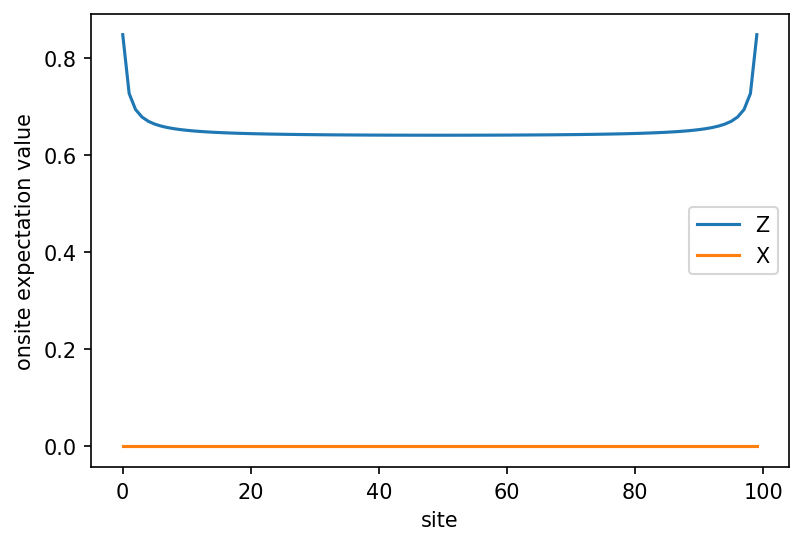

In [8]:
# onsite expectation values

X = psi.expectation_value("Sigmax")
Z = psi.expectation_value("Sigmaz")
x = np.arange(psi.L)
plt.figure()
plt.plot(x, Z, label="Z")
plt.plot(x, X, label="X")   # note: it's clear that this is zero due to charge conservation!
plt.xlabel("site")
plt.ylabel("onsite expectation value")
plt.legend()
plt.show()

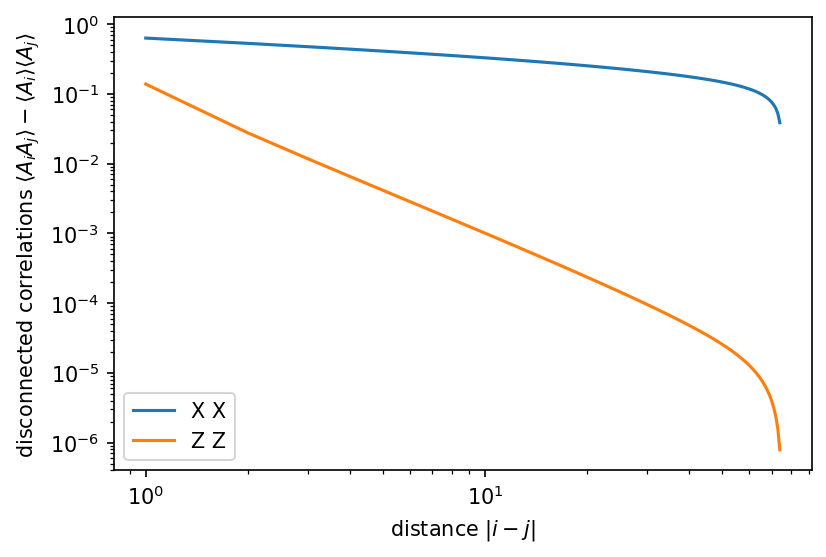

In [9]:
# correlation functions

i0 = psi.L // 4  # for fixed `i`
j = np.arange(i0 + 1, psi.L)
XX = psi.term_correlation_function_right([("Sigmax", 0)], [("Sigmax", 0)], i_L=i0, j_R=j)
XX_disc = XX - X[i0] * X[j]
ZZ = psi.term_correlation_function_right([("Sigmaz", 0)], [("Sigmaz", 0)], i_L=i0, j_R=j)
ZZ_disc = ZZ - Z[i0] * Z[j]

dx = j - i0
plt.figure()
plt.plot(dx, XX_disc, label="X X")
plt.plot(dx, ZZ_disc, label="Z Z")
plt.xlabel(r"distance $|i-j|$")
plt.ylabel(r"disconnected correlations $\langle A_i A_j\rangle - \langle A_i \rangle\langle A_j\rangle$")
plt.legend()
plt.loglog()
plt.show()

We find power-law decaying correlations, as expected for a critical model.
For a gapped model, we would expect exponentially decaying correlations.

----

We now look at the entanglement entropy. The transverse-field Ising model is critical at $g=J$.
Conformal field theory, [Calabrese,Cardy 2004](https://arxiv.org/abs/hep-th/0405152), predicts an entanglement entropy profile of

$$S(l, L) = \frac{c}{6} \log\left(\frac{2L}{\pi a} \sin\left(\frac{\pi l}{L}\right)\right) + \textrm{const}$$

where $c=0.5$ is the central charge, $a$ is the lattice spacing (we set $a=1$), $L$ is the total size of the system and we consider subsystems of size $l$ and $L-l$ as left/right.
Note that this yields the familiar $S(L/2, L) = \frac{c}{6} \log(L) + \textrm{const}$ for the half-chain entropy as a function of system size.

extraced central charge 0.50788 with residuum 1.95e-09
(Expect central charge = 0.5 for the transverse field Ising model.)


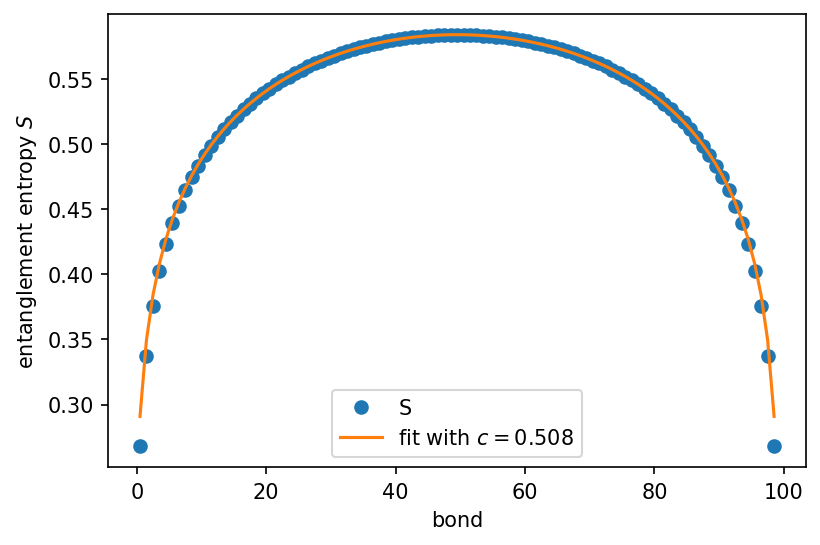

In [10]:
S = psi.entanglement_entropy()

bonds = np.arange(0.5, psi.L-1)
plt.plot(bonds, S, 'o', label="S")

# preform fit to extract the central charge
central_charge, const, res = tenpy.tools.fit.central_charge_from_S_profile(psi)
fit = tenpy.tools.fit.entropy_profile_from_CFT(bonds + 0.5, psi.L, central_charge, const)
print(f"extraced central charge {central_charge:.5f} with residuum {res:.2e}")
print("(Expect central charge = 0.5 for the transverse field Ising model.)")
plt.plot(bonds, fit, label=f"fit with $c={central_charge:.3f}$")
plt.xlabel("bond")
plt.ylabel("entanglement entropy $S$")
plt.legend()
plt.show()